In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
(X_Train,_),(_,_) = mnist.load_data()

In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train=X_Train.reshape((*X_Train.shape,1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
# Normalize this data [-1,1]
X_Train=(X_Train.astype('float32')-127.5)/127.5
print(np.min(X_Train))
print(np.max(X_Train))

print(X_Train.shape)

-1.0
1.0
(60000, 28, 28, 1)


In [5]:
TOTAL_EPOCHS=50
BATCH_SIZE=256
NO_OF_BATCHES=math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE=int(BATCH_SIZE/2)
NOISE_DIM=100   # Upsample into 784 dim vector

# Use these adam parameters for gans
adam=Adam(lr=2e-4,beta_1=0.5)

In [6]:
# Define the generator
generator=Sequential()

generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double activation size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double activation size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=(5,5),padding='same',activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0

In [7]:
# Discriminator
discriminator=Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Next Conv Layer (14 X 14 X 64 --> 7 X 7 X 128)
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))

# Flatten
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [8]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

        
def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('DCGANS_IMAGES/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

Epoch 1 D loss: 60.997849 G loss: 60.704167
Epoch 2 D loss: 180.671391 G loss: 199.994751
Epoch 3 D loss: 167.332985 G loss: 207.459906
Epoch 4 D loss: 165.913547 G loss: 200.114343
Epoch 5 D loss: 165.510291 G loss: 197.935645
Epoch 6 D loss: 164.442328 G loss: 196.337433
Epoch 7 D loss: 163.676540 G loss: 195.304209
Epoch 8 D loss: 163.215733 G loss: 195.621185
Epoch 9 D loss: 162.763869 G loss: 194.963281
Epoch 10 D loss: 162.445951 G loss: 195.334536


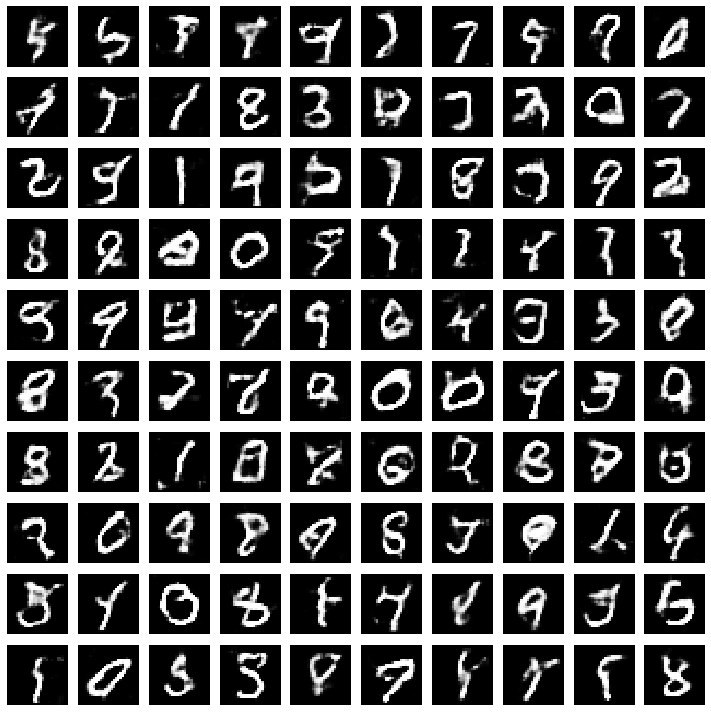

Epoch 11 D loss: 162.288079 G loss: 193.968294
Epoch 12 D loss: 161.858492 G loss: 196.107965
Epoch 13 D loss: 161.939814 G loss: 194.933992
Epoch 14 D loss: 161.627564 G loss: 195.720141
Epoch 15 D loss: 161.578407 G loss: 195.930929
Epoch 16 D loss: 161.507617 G loss: 195.804202
Epoch 17 D loss: 161.429896 G loss: 194.590836
Epoch 18 D loss: 161.425302 G loss: 194.626108
Epoch 19 D loss: 161.140660 G loss: 197.553782
Epoch 20 D loss: 161.221758 G loss: 194.779669


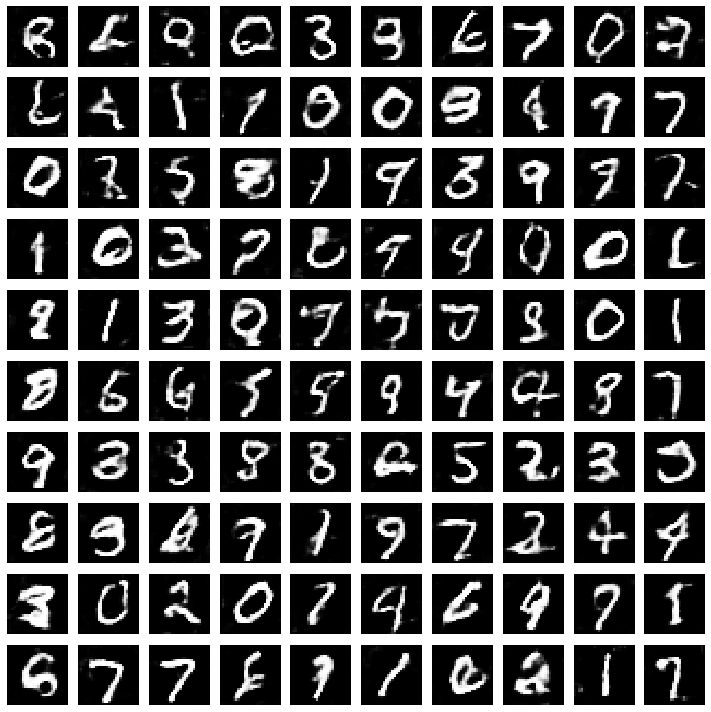

Epoch 21 D loss: 161.137549 G loss: 195.127122
Epoch 22 D loss: 160.917881 G loss: 197.583852
Epoch 23 D loss: 160.863387 G loss: 196.201085
Epoch 24 D loss: 160.954477 G loss: 195.589070
Epoch 25 D loss: 160.778214 G loss: 196.149220
Epoch 26 D loss: 160.764245 G loss: 196.128043
Epoch 27 D loss: 160.151358 G loss: 201.762340
Epoch 28 D loss: 160.559596 G loss: 196.511246
Epoch 29 D loss: 160.453088 G loss: 196.776802
Epoch 30 D loss: 160.326738 G loss: 197.980429


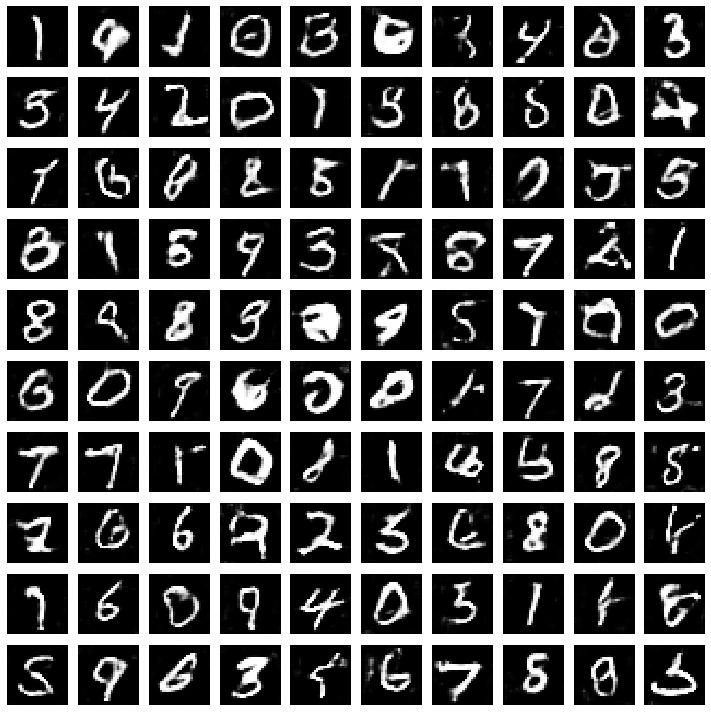

Epoch 31 D loss: 160.310835 G loss: 197.944438


In [ ]:
for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%10==0:
        generator.save('DCGANS_models/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)
       

    